# Homework - week 6

## Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [40]:
## Settings
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## Data import

In [3]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY


## Data preparation

In [4]:
cols = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity']

df = data[cols].fillna(0)

In [5]:
df.median_house_value = np.log1p(df.median_house_value)

## Split the data

In [8]:
def split_data(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_full_train = df_full_train.reset_index(drop=True)

    y_train = df_train.median_house_value.values
    y_val = df_val.median_house_value.values
    y_test = df_test.median_house_value.values

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    return df_train, df_val, df_test, y_train, y_val, y_test
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)

In [14]:
def vectorize_df(df, dv = None, fit:bool = False):
    dicts = df.fillna(0).to_dict(orient='records')
    if fit == True:
        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(dicts)
        return X, dv
    else:
        X = dv.fit_transform(dicts)
        return X


In [15]:
X_train, dv = vectorize_df(df_train, fit=True)
X_val = vectorize_df(df_val, dv)

## Question 1

In [17]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

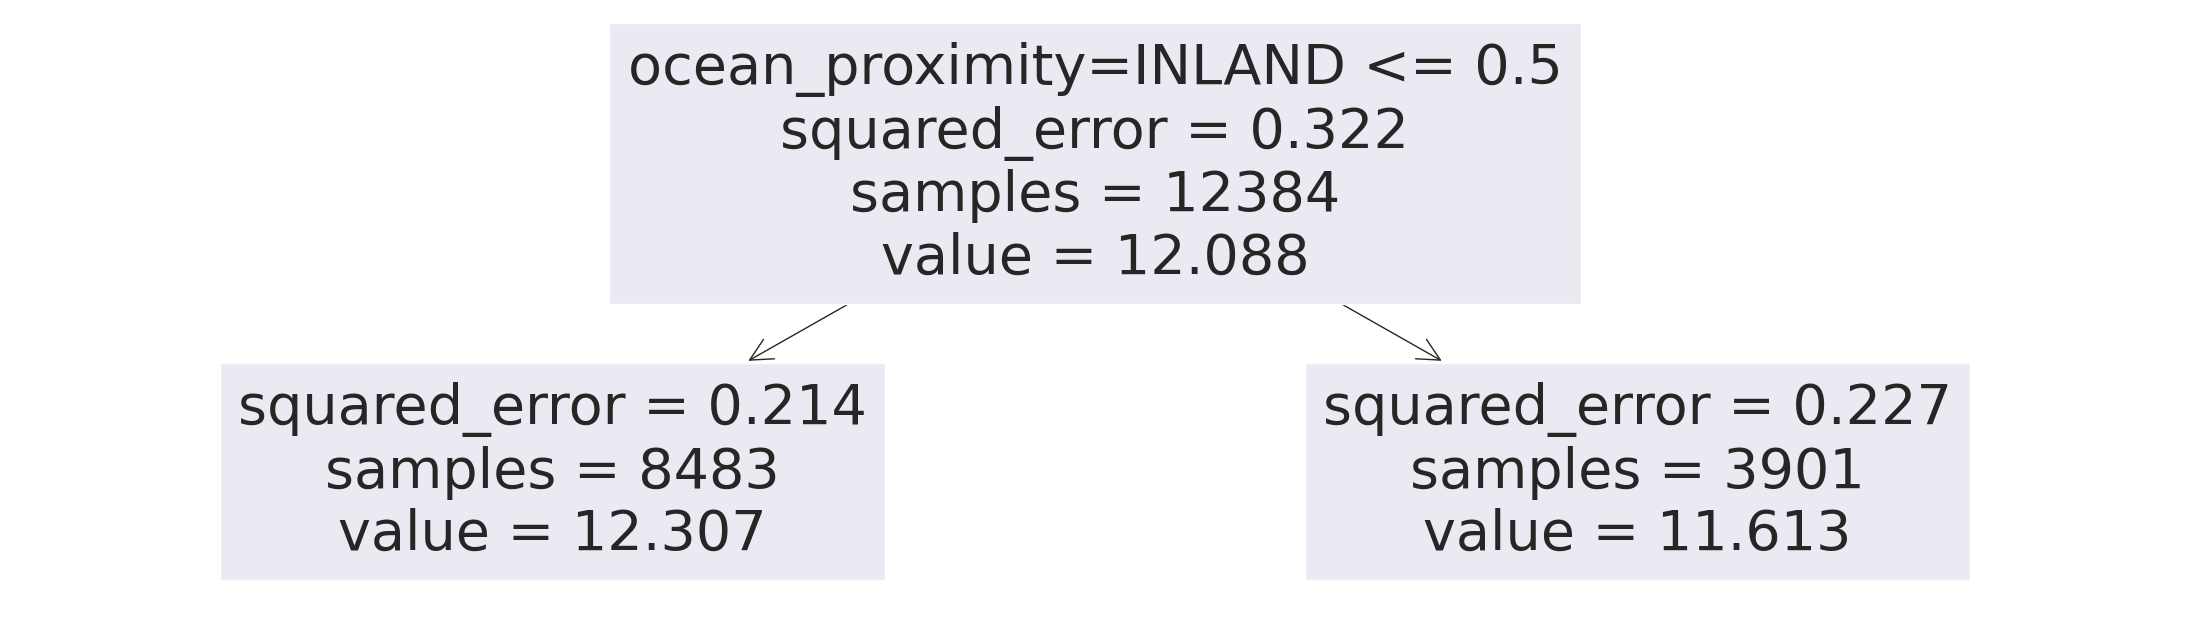

In [24]:
from sklearn.tree import plot_tree
plt.figure(figsize=(28,8))
plot_tree(dt, feature_names=dv.get_feature_names_out(), class_names=['ok','default']);

## Question 2

In [31]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
y_pred = rf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))

y_pred = rf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))

print('Train:', rmse_train)
print('Validation:', rmse_val)

Train: 0.10452317313272029
Validation: 0.245928895646822


## Question 3

<AxesSubplot:xlabel='n_estimators'>

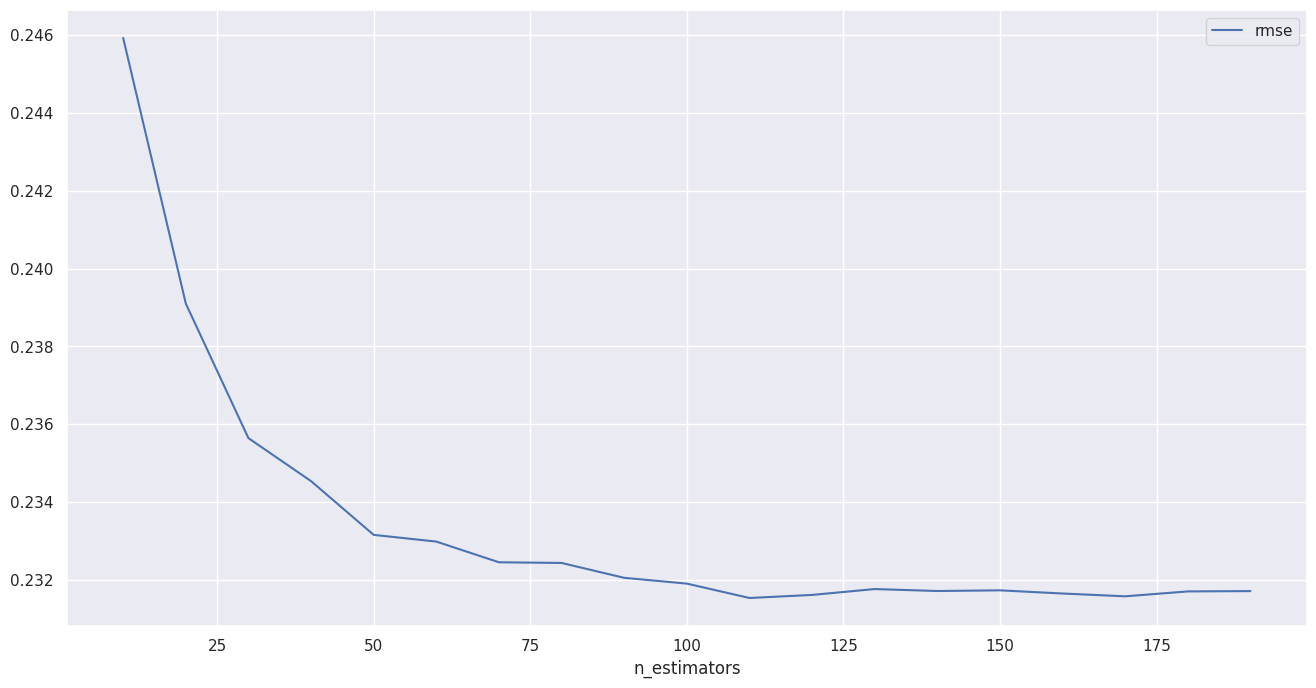

In [41]:
scores=[]
for n in range(10,200,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n,rmse))
pd.DataFrame(scores, columns=['n_estimators', 'rmse']).plot(x='n_estimators', y='rmse')

## Question 4

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

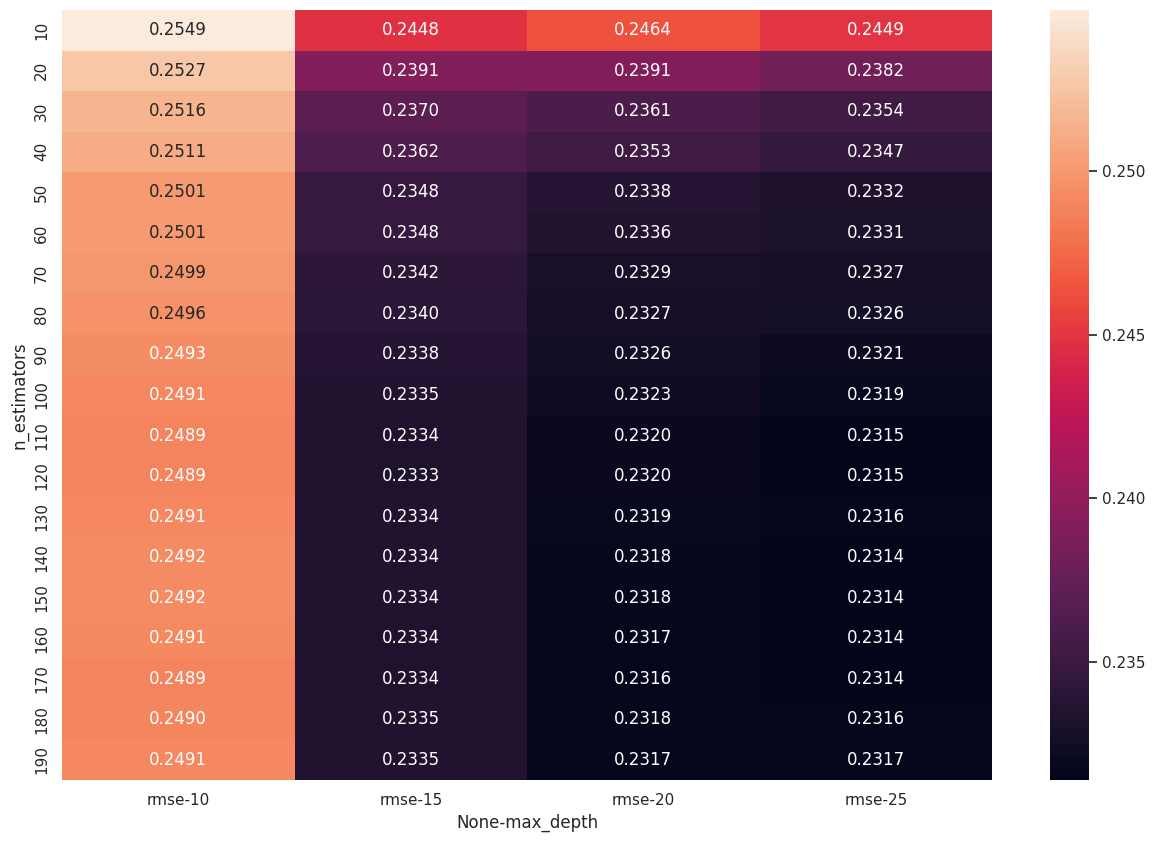

In [42]:
scores=[]
for n in range(10,200,10):
    for d in [10,15,20,25]:
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n,d,rmse))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])

df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
plt.figure(figsize=(15,10))
sns.heatmap(df_scores_pivot, annot=True, fmt='.4f')

## Question 5

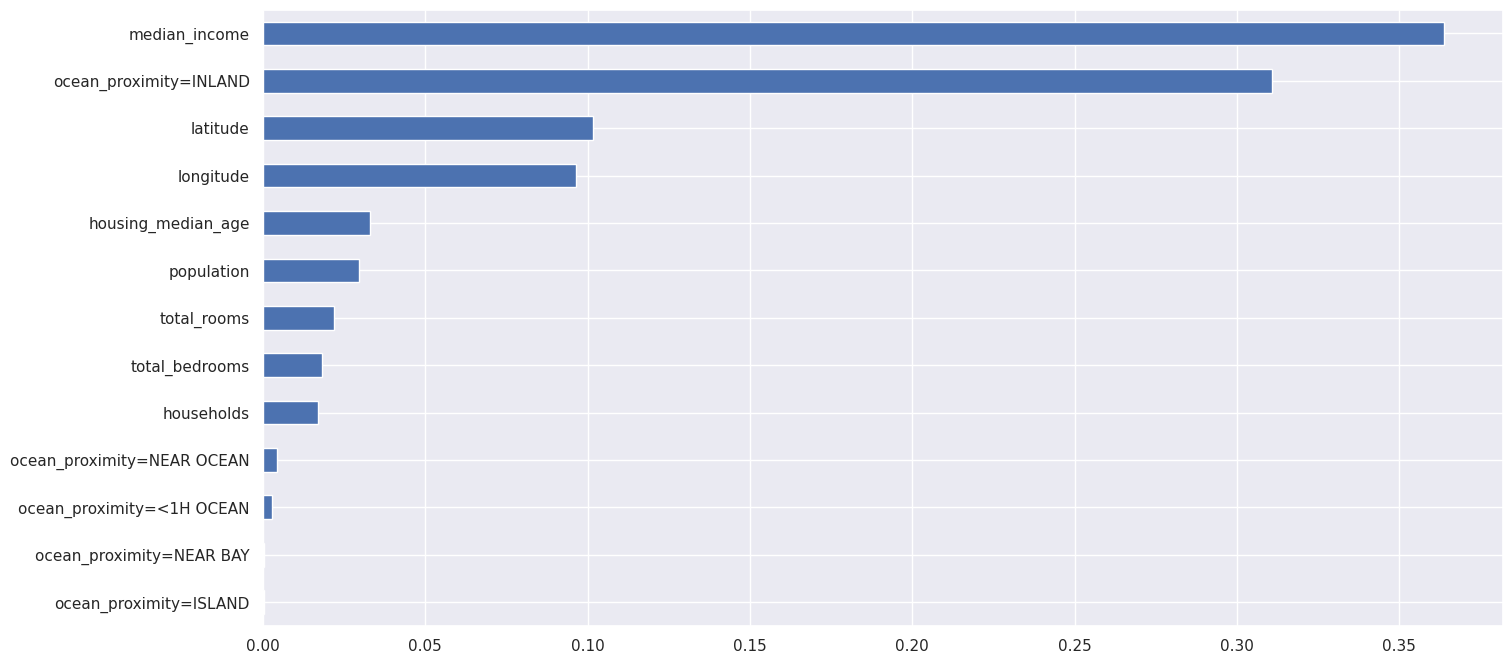

In [52]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
scores = pd.Series(dtype='float64')
for name, value in zip(dv.get_feature_names_out(), rf.feature_importances_):
    scores[name] = value
scores.sort_values(ascending=True).plot(kind='barh');

## Question 6

In [57]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'ocean_proximity=ISLAND',
       'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN',
       'population', 'total_bedrooms', 'total_rooms'], dtype=object)

In [59]:
features = [x.replace('<','') for x in dv.get_feature_names_out()]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [71]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [72]:
scores = {}

In [73]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
watchlist = [(dtrain,'train'),(dval,'validation')]

model = xgb.train(xgb_params, dtrain,
                evals=watchlist,
                verbose_eval=5,
                num_boost_round=100)            

In [74]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.3'])

In [75]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
watchlist = [(dtrain,'train'),(dval,'validation')]

model = xgb.train(xgb_params, dtrain,
                evals=watchlist,
                verbose_eval=5,
                num_boost_round=100)            

In [76]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

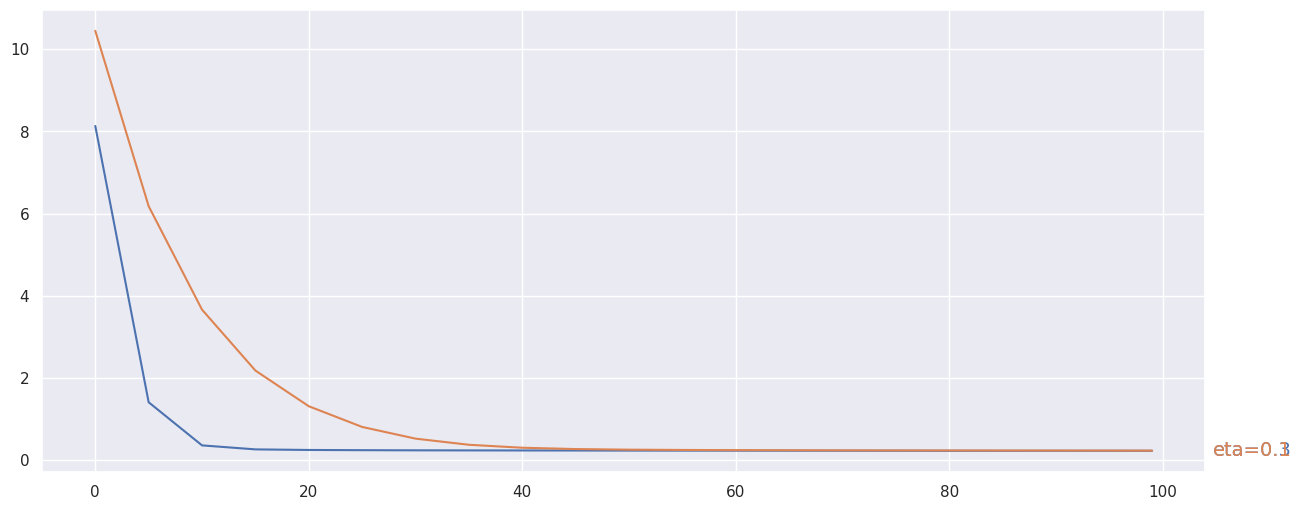

In [82]:
plt.figure(figsize=(15,6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.rmse, label=key)

ax = plt.gca()
for line, key in zip(ax.lines, scores.keys()):
    y = line.get_ydata()[-1]
    ax.annotate(key, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
plt.show()